Number of samples in the training set: 12426
Number of samples in the validation set: 1764
Number of samples in the test set: 3672
Train data X shape: (12426, 768)
Train data y shape: (12426, 3, 3)
Train, validation, and test set target distributions:
count                                                 12426
unique                                                 4142
top       [[0.09, 0.1, 0.02], [0.04, 0.07, 0.02], [0.03,...
freq                                                      3
Name: urban_imperviousness, dtype: object
count                                                  1764
unique                                                  588
top       [[0.07, 0.03, 0.01], [0.01, 0.04, 0.05], [0.0,...
freq                                                      3
Name: urban_imperviousness, dtype: object
count                                                  3672
unique                                                 1224
top       [[0.0, 0.0, 0.29], [0.0, 0.0, 0.08], [0.0, 0.0...
freq

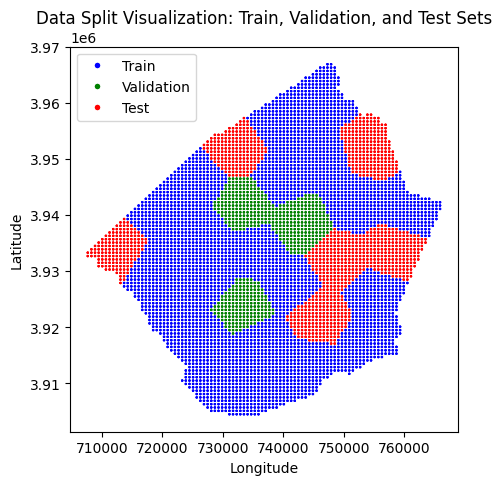

In [12]:
import os
import pickle as pkl
import pandas as pd
import numpy as np
import geopandas as gpd
import glob
import random
from datetime import datetime
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio import plot
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Set a fixed random seed for reproducibility
random.seed(19)

# Path to save the final DataFrame
output_pkl_path = "../data/data_final.pkl"
with open(output_pkl_path, "rb") as f:
    gdf = pkl.load(f)
    
to_pred_gdf = gdf.loc[gdf['date'] >= pd.to_datetime('2017-01-01 00:00:00')].reset_index(drop=True)
gdf_train_test = gdf.loc[gdf['date'] < pd.to_datetime('2017-01-01 00:00:00')].reset_index(drop=True)

# Extract centroid coordinates of each tile
gdf_train_test['centroid'] = gdf_train_test.geometry.centroid

# Decide on the number of clusters
n_clusters = 30  # Adjust based on your requirements
# Use coordinates without scaling
coords = np.array([[geom.x, geom.y] for geom in gdf_train_test['centroid']])
# Apply KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=19)
gdf_train_test['cluster'] = kmeans.fit_predict(coords)

# Get unique clusters
clusters = gdf_train_test['cluster'].unique()
np.random.shuffle(clusters)

# Split clusters into train, validation, and test sets
train_clusters = clusters[:21]   # (70%)
val_clusters = clusters[21:24]   # (10%)
test_clusters = clusters[24:]    # (20%)

# Filter the original DataFrame to create the train, validation, and test DataFrames
train_gdf = gdf_train_test[gdf_train_test['cluster'].isin(train_clusters)].reset_index(drop=True)
val_gdf = gdf_train_test[gdf_train_test['cluster'].isin(val_clusters)].reset_index(drop=True)
test_gdf = gdf_train_test[gdf_train_test['cluster'].isin(test_clusters)].reset_index(drop=True)


# Define feature and target columns
X_cols = [col for col in gdf_train_test.columns if col.startswith('feature')]
y_col = 'urban_imperviousness'

# Prepare data arrays for train, validation, and test
X_train = train_gdf[X_cols]
y_train = np.stack(train_gdf[y_col].values).reshape(-1, 3, 3)

X_val = val_gdf[X_cols]
y_val = np.stack(val_gdf[y_col].values).reshape(-1, 3, 3)

X_test = test_gdf[X_cols]
y_test = np.stack(test_gdf[y_col].values).reshape(-1, 3, 3)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 9), dtype=torch.float32)  # Flattened 3x3 grids

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.reshape(-1, 9), dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 9), dtype=torch.float32)

# Create a mapping from clusters to sets
cluster_to_set = {}
for cluster in train_clusters:
    cluster_to_set[cluster] = 'Train'
for cluster in val_clusters:
    cluster_to_set[cluster] = 'Validation'
for cluster in test_clusters:
    cluster_to_set[cluster] = 'Test'

# Map the 'cluster' column to 'set' labels
gdf_train_test['set'] = gdf_train_test['cluster'].map(cluster_to_set)

# Display the number of samples in each split
print(f"Number of samples in the training set: {len(train_gdf)}")
print(f"Number of samples in the validation set: {len(val_gdf)}")
print(f"Number of samples in the test set: {len(test_gdf)}")

print("Train data X shape:", X_train.values.shape)
print("Train data y shape:", y_train.shape)

print("Train, validation, and test set target distributions:")
# Training set distribution
print(train_gdf['urban_imperviousness'].describe())
# Validation set distribution
print(val_gdf['urban_imperviousness'].describe())
# Test set distribution
print(test_gdf['urban_imperviousness'].describe())


# Plot the data points colored by 'set'
plt.figure(figsize=(5, 5))

# Define colors for each set
colors = {'Train': 'blue', 'Validation': 'green', 'Test': 'red'}

# Map 'set' labels to colors
point_colors = gdf_train_test['set'].map(colors)

# Plot
plt.scatter(coords[:, 0], coords[:, 1], c=point_colors, s=0.5)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Train', markerfacecolor='blue', markersize=5),
    Line2D([0], [0], marker='o', color='w', label='Validation', markerfacecolor='green', markersize=5),
    Line2D([0], [0], marker='o', color='w', label='Test', markerfacecolor='red', markersize=5)
]

plt.legend(handles=legend_elements, loc='best')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Data Split Visualization: Train, Validation, and Test Sets')
plt.show()

In [13]:
# Baseline Model

# Calculate the mean urban imperviousness for each cell in the 3x3 grid across the training set
baseline_prediction = np.mean(y_train, axis=0)
print("Baseline prediction (3x3 grid):\n", baseline_prediction)

# Flatten the true and predicted 3x3 grids to apply the metrics for the test set
y_test_flat = y_test.reshape(-1, 9)  # Flatten each 3x3 grid in y_test to a 9-element vector

# Repeat the baseline prediction for each sample in y_test for comparison
baseline_pred = np.tile(baseline_prediction.flatten(), (y_test_flat.shape[0], 1))

# Calculate baseline metrics on the test set
mse_baseline = mean_squared_error(y_test_flat, baseline_pred)
mae_baseline = mean_absolute_error(y_test_flat, baseline_pred)

print(f"Baseline MSE on Test Set: {mse_baseline}")
print(f"Baseline MAE on Test Set: {mae_baseline}")

Baseline prediction (3x3 grid):
 [[0.02977058 0.03130609 0.03007974]
 [0.03052863 0.03056007 0.02993484]
 [0.02947853 0.03011104 0.02973191]]
Baseline MSE on Test Set: 0.003938400652259588
Baseline MAE on Test Set: 0.03570465371012688


In [61]:
# Define a custom weighted MSE loss function to address data imbalance

class WeightedMSELoss(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(WeightedMSELoss, self).__init__()
        self.epsilon = epsilon  # Small value to avoid division by zero

    def forward(self, input, target):
        # Weights proportional to target values
        weights = target + self.epsilon
        loss = weights * (input - target) ** 2
        return torch.mean(loss)

def train_model(
    model, 
    X_train_tensor, 
    y_train_tensor, 
    X_val_tensor=None, 
    y_val_tensor=None, 
    epochs=100, 
    criterion=None,  
    optimizer=None, 
    scheduler=None,
    lr=0.001, 
    batch_size=32, 
    verbose=True,
    use_batch_processing=True, 
    early_stopping=False,  
    patience=10,  
    min_delta=0.0 
):
    # Set up criterion if none is provided
    if criterion is None:
        criterion = nn.MSELoss()

    # Set up optimizer if none is provided
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=lr)

    # Create DataLoader for batch processing if enabled
    if use_batch_processing:
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    else:
        # No batch processing; use the entire dataset in each pass
        train_loader = [(X_train_tensor, y_train_tensor)]

    # Early stopping initialization
    best_loss = float('inf')
    patience_counter = 0

    # Initialize lists to record loss history
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss = 0
        for X_batch, y_batch in train_loader:
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Calculate average training loss
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)  # Record training loss

        # Validation phase
        if X_val_tensor is not None and y_val_tensor is not None:
            model.eval()  # Set model to evaluation mode
            with torch.no_grad():
                val_outputs = model(X_val_tensor)
                val_loss = criterion(val_outputs, y_val_tensor).item()
            val_losses.append(val_loss)  # Record validation loss

            # Adjust learning rate with scheduler
            if scheduler is not None:
                scheduler.step(val_loss)

            # Early stopping
            if early_stopping:
                # Check for improvement
                if val_loss < best_loss - min_delta:
                    best_loss = val_loss
                    patience_counter = 0  # Reset patience if there is improvement
                else:
                    patience_counter += 1  # Increment patience if no improvement

                # Stop training if patience is exceeded
                if patience_counter >= patience:
                    if verbose:
                        print(f"Early stopping at epoch {epoch + 1} with Validation Loss: {best_loss:.6f}")
                    break
        else:
            # If no validation data, consider using training loss for scheduler
            if scheduler is not None:
                scheduler.step(avg_loss)
            val_losses.append(None)

        # Print epoch loss every 10 epochs if verbose is enabled
        if verbose and (epoch + 1) % 10 == 0:
            msg = f'Epoch [{epoch + 1}/{epochs}], Training Loss: {avg_loss:.6f}'
            if X_val_tensor is not None and y_val_tensor is not None:
                msg += f', Validation Loss: {val_loss:.6f}'
            print(msg)

    return model, train_losses, val_losses

def plot_train_val_losses(train_losses, val_losses):
    # Create a range for the number of epochs
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(6, 3))
    plt.plot(epochs_range, train_losses, label='Training Loss')
    # Check if validation losses are recorded (not None)
    if any(v is not None for v in val_losses):
        plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()

Epoch [10/100], Training Loss: 0.002077, Validation Loss: 0.005853
Epoch [20/100], Training Loss: 0.000897, Validation Loss: 0.003523
Epoch [30/100], Training Loss: 0.000689, Validation Loss: 0.003541
Early stopping at epoch 35 with Validation Loss: 0.003807
SimpleNN MSE on Test Set: 0.002329290146008134
SimpleNN MAE on Test Set: 0.02212701365351677


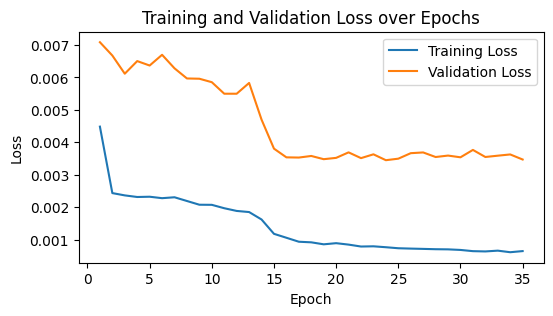

In [59]:
# Simple fully connected (dense) neural network 

class SimpleNN(nn.Module):
    def __init__(self, input_size=768, output_size=9, hidden_units=128):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units, output_size)  # Output layer matches the size of the 3x3 grid
    
    def forward(self, x):
        # Apply logit transformation at the input layer
        x = torch.clamp(x, min=1e-6, max=1 - 1e-6) # Avoid 0 and 1 to prevent logit issues
        x = torch.log(x / (1 - x))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)  # Apply sigmoid to get output back in [0, 1] range
        return x

# Train the model using the train_model function
simple_nn_model = SimpleNN(input_size=768, output_size=9, hidden_units=128)
trained_simple_nn_model, snn_train_losses, snn_val_losses = train_model(
    model=simple_nn_model,
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_val_tensor=X_val_tensor,  # Validation data
    y_val_tensor=y_val_tensor,  # Validation target
    criterion=nn.SmoothL1Loss(),
    epochs=100,
    lr=0.0005,
    batch_size=64,
    verbose=True,
    use_batch_processing=True,
    early_stopping=True,  # Enable early stopping
    patience=20,  # Wait for 20 epochs without improvement
    min_delta=0.0005  # Minimum loss improvement to reset patience
)
# Prediction on test data
with torch.no_grad():
    snn_pred = trained_simple_nn_model(X_test_tensor)

# Calculate metrics
mse_snn = nn.MSELoss()(snn_pred, y_test_tensor).item()
mae_snn = nn.L1Loss()(snn_pred, y_test_tensor).item()

print(f"SimpleNN MSE on Test Set: {mse_snn}")
print(f"SimpleNN MAE on Test Set: {mae_snn}")

plot_train_val_losses(snn_train_losses, snn_val_losses)

Epoch [10/100], Training Loss: 0.000993, Validation Loss: 0.003341
Epoch [20/100], Training Loss: 0.000637, Validation Loss: 0.003505
Epoch [30/100], Training Loss: 0.000513, Validation Loss: 0.003833
Early stopping at epoch 40 with Validation Loss: 0.003341
DeepNN MSE on Test Set: 0.0023036873899400234
DeepNN MAE on Test Set: 0.021146345883607864


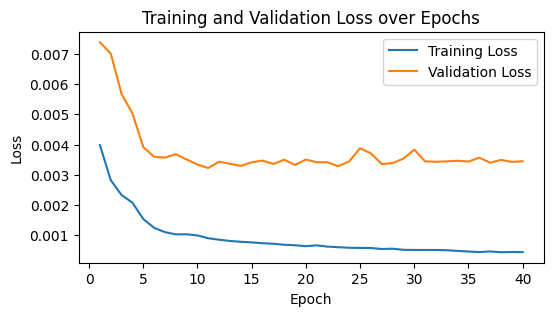

In [60]:
# Deep Fully Connected Neural Network

class DeepNN(nn.Module):
    def __init__(self, input_size=768, output_size=9, hidden_units=128):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, output_size)  # Output layer matches 3x3 grid size

    def forward(self, x):
        # Apply logit transformation at the input layer
        x = torch.clamp(x, min=1e-6, max=1 - 1e-6) # Avoid 0 and 1 to prevent logit issues
        x = torch.log(x / (1 - x))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = torch.sigmoid(x) # Apply sigmoid to get output back in [0, 1] range
        return x

# Train the model using the train_model function
deep_nn_model = DeepNN(input_size=768, output_size=9, hidden_units=128)
trained_deep_nn_model, dnn_train_losses, dnn_val_losses = train_model(
    model=deep_nn_model,
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_val_tensor=X_val_tensor,  
    y_val_tensor=y_val_tensor, 
    criterion=nn.SmoothL1Loss(),
    epochs=100,
    lr=0.0005,
    batch_size=64,
    verbose=True,
    use_batch_processing=True,
    early_stopping=True, 
    patience=30, 
    min_delta=0.0005  
)

# Prediction on test data
with torch.no_grad():
    dnn_pred = trained_deep_nn_model(X_test_tensor)

# Calculate metrics
mse_dnn = nn.MSELoss()(dnn_pred, y_test_tensor).item()
mae_dnn = nn.L1Loss()(dnn_pred, y_test_tensor).item()

print(f"DeepNN MSE on Test Set: {mse_dnn}")
print(f"DeepNN MAE on Test Set: {mae_dnn}")

plot_train_val_losses(dnn_train_losses, dnn_val_losses)

Epoch [10/100], Training Loss: 0.002922, Validation Loss: 0.007837
Epoch [20/100], Training Loss: 0.002918, Validation Loss: 0.007837
Epoch [30/100], Training Loss: 0.001323, Validation Loss: 0.003307
Epoch [40/100], Training Loss: 0.001146, Validation Loss: 0.003154
Epoch [50/100], Training Loss: 0.001035, Validation Loss: 0.003164
Epoch [60/100], Training Loss: 0.000940, Validation Loss: 0.003102
Epoch [70/100], Training Loss: 0.000902, Validation Loss: 0.003121
Epoch [80/100], Training Loss: 0.000867, Validation Loss: 0.003101
Epoch [90/100], Training Loss: 0.000839, Validation Loss: 0.003153
Epoch [100/100], Training Loss: 0.000833, Validation Loss: 0.003160
DOWD DeepNN MSE on Test Set: 0.002240
DOWD DeepNN MAE on Test Set: 0.023527


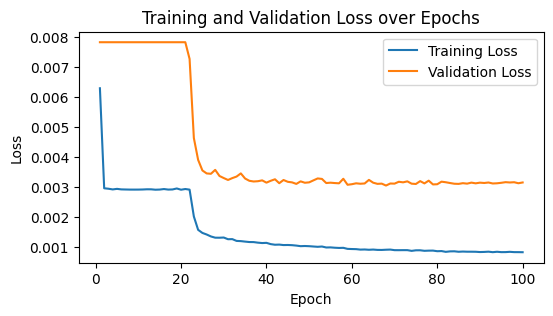

In [62]:
# Adjusted DeepNN with Dropout and Weight Decay

class DOWDDeepNN(nn.Module):
    def __init__(self, input_size=768, output_size=9, hidden_units=64, dropout_rate=0.5):
        super(DOWDDeepNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(hidden_units, output_size)
    
    def forward(self, x):
        x = torch.clamp(x, min=1e-6, max=1 - 1e-6)
        x = torch.log(x / (1 - x))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

# Instantiate the model
dowd_dnn_model = DOWDDeepNN(input_size=768, output_size=9, hidden_units=64, dropout_rate=0.2)
# Define optimizer with weight decay
optimizer = optim.Adam(dowd_dnn_model.parameters(), lr=0.0005, weight_decay=1e-5)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
criterion = nn.SmoothL1Loss()

# Train the model
trained_dowd_dnn_model, dowd_dnn_train_losses, dowd_dnn_val_losses = train_model(
    model=dowd_dnn_model,
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_val_tensor=X_val_tensor,
    y_val_tensor=y_val_tensor,
    epochs=100,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    lr=0.0005,
    batch_size=64,
    verbose=True,
    use_batch_processing=True,
    early_stopping=False
)

# Prediction on test data
with torch.no_grad():
    dowd_dnn_pred = trained_dowd_dnn_model(X_test_tensor)

# Calculate metrics
mse_dowd_dnn = nn.MSELoss()(dowd_dnn_pred, y_test_tensor).item()
mae_dowd_dnn = nn.L1Loss()(dowd_dnn_pred, y_test_tensor).item()

print(f"DOWD DeepNN MSE on Test Set: {mse_dowd_dnn:.6f}")
print(f"DOWD DeepNN MAE on Test Set: {mae_dowd_dnn:.6f}")

plot_train_val_losses(dowd_dnn_train_losses, dowd_dnn_val_losses)

Epoch [10/100], Training Loss: 0.001230, Validation Loss: 0.003302
Epoch [20/100], Training Loss: 0.000983, Validation Loss: 0.003289
Epoch [30/100], Training Loss: 0.000818, Validation Loss: 0.003332
Early stopping at epoch 34 with Validation Loss: 0.003444
Improved DeepNN MSE on Test Set: 0.0021782515104860067
Improved DeepNN MAE on Test Set: 0.022065114229917526


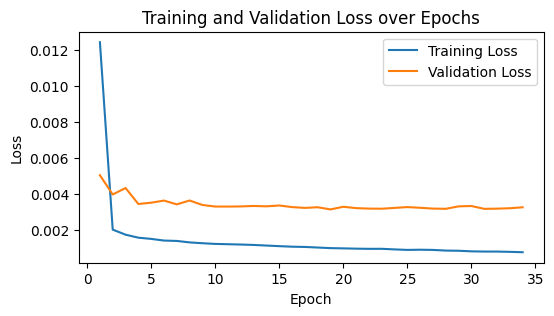

In [64]:
class ImprovedDeepNN(nn.Module):
    def __init__(self, input_size=768, output_size=9, hidden_units=256, num_layers=6, dropout_rate=0.3):
        super(ImprovedDeepNN, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_units))
        layers.append(nn.BatchNorm1d(hidden_units))
        layers.append(nn.LeakyReLU())
        layers.append(nn.Dropout(p=dropout_rate))
        
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_units, hidden_units))
            layers.append(nn.BatchNorm1d(hidden_units))
            layers.append(nn.LeakyReLU())
            layers.append(nn.Dropout(p=dropout_rate))
        
        layers.append(nn.Linear(hidden_units, output_size))
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        x = torch.clamp(x, min=1e-6, max=1 - 1e-6)
        x = torch.log(x / (1 - x))
        x = self.net(x)
        x = torch.sigmoid(x)
        return x

improved_model = ImprovedDeepNN()
optimizer = optim.Adam(improved_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

trained_improved_model, idnn_train_losses, idnn_val_losses = train_model(
    model=improved_model,
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_val_tensor=X_val_tensor,
    y_val_tensor=y_val_tensor,
    criterion=nn.SmoothL1Loss(),
    epochs=100,
    lr=0.0005,
    batch_size=64,
    verbose=True,
    use_batch_processing=True,
    early_stopping=True, 
    patience=20, 
    min_delta=0.0005  
)

# Prediction on test data
with torch.no_grad():
    improved_pred = trained_improved_model(X_test_tensor)

# Calculate metrics
mse_improved = nn.MSELoss()(improved_pred, y_test_tensor).item()
mae_improved = nn.L1Loss()(improved_pred, y_test_tensor).item()

print(f"Improved DeepNN MSE on Test Set: {mse_improved}")
print(f"Improved DeepNN MAE on Test Set: {mae_improved}")

plot_train_val_losses(idnn_train_losses, idnn_val_losses)



- Adjust Training Process:
    * Hyperparameter Tuning:
        - Systematically explore different hyperparameters using grid search or Bayesian optimization.
            * Regularization (e.g., higher dropout rates, weight decay might prevent overfitting)
            * Adjust early stopping criteria and learning rate schedules to improve training dynamics
            * The number and content of NN layers (SNN vs. DNN)
    * For each hyperparameter combination, create a unique model name that corresponds to the
      selected hyperparameters. Calculate predictions and metrics (RMSE, MSE, and MAE) for the test set. 
      Then, save all model artifacts (all hyperparameters and model architecture, fitted model, 
      train losses, val. losses, predictions, and metrics) as a dictionary to a pickle file using the
      unique model name.
    * For the training loop process, it should always check first to see if a model of that name has already 
      been saved. That way, if the process is interrupted, it can continue from the last spot.
      

------

- Re-evaluate the Target Variable:
    * Target Transformation:
        - Apply transformations to the target variable (e.g., log transformation) to stabilize variance and improve model learning.
- Model Evaluation and Validation:
    * Cross-Validation:
        - Employ k-fold cross-validation to get a more robust estimate of model performance.
    * Error Analysis:
        - Analyze prediction errors to identify patterns or specific cases where the model performs poorly.
    * Ensemble Methods:
        - Combine predictions from multiple models to improve overall performance.
- Feature Engineering:
    * Include Additional Features:
        - Incorporate additional spectral indices (e.g., NDVI, NDWI) that are indicative of urban areas.
    * Spatial Context:
        - Include neighboring tiles or use techniques like patch-based models to capture more spatial context.
    * Feature Importance:
        - Use techniques like SHAP values to understand which features the model is relying on, and adjust accordingly.




In [ ]:
# Calculate RMSE for each model
rmse_baseline = np.sqrt(mse_baseline)
rmse_snn = np.sqrt(mse_snn)
rmse_dnn = np.sqrt(mse_dnn)
rmse_idnn = np.sqrt(mse_improved)

# Create a summary table
metrics_summary = pd.DataFrame({
    'Model': ['Baseline', 'SimpleNN', 'DeepNN', 'ImprovedDeepNN'],
    'MSE': [mse_baseline, mse_snn, mse_dnn, mse_improved],
    'RMSE': [rmse_baseline, rmse_snn, rmse_dnn, rmse_idnn],
    'MAE': [mae_baseline, mae_snn, mae_dnn, mae_improved]
})
print(metrics_summary)


            Model       MSE      RMSE       MAE
0        Baseline  0.003938  0.062757  0.035705
1        SimpleNN  0.002532  0.050321  0.023185
2          DeepNN  0.003160  0.056215  0.028980
3  ImprovedDeepNN  0.002216  0.047073  0.023099
4       DeepResNN  0.215372  0.464082  0.236552
5             SNN  0.004582  0.067690  0.025763


<module 'matplotlib.pyplot' from 'c:\\Users\\bento\\gis582\\project\\env\\Lib\\site-packages\\matplotlib\\pyplot.py'>

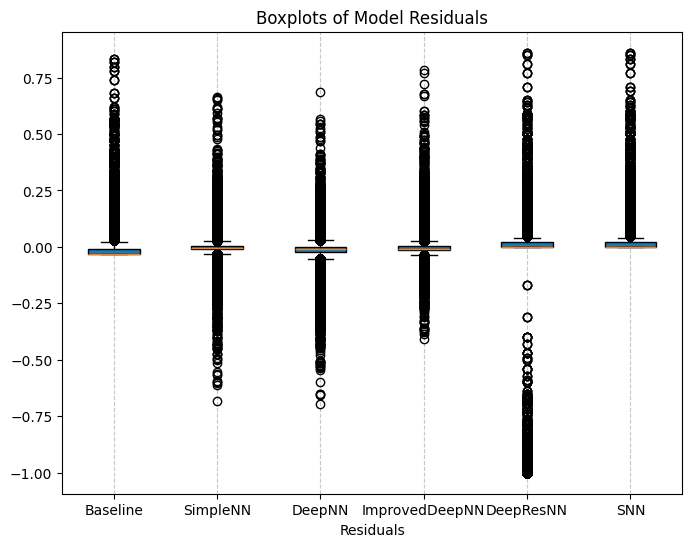

In [43]:
# Flatten predictions and ground truth for residual analysis
def res_plot(y_tensor, yhat_tensors, labels, title="", figsize=(10, 5)):
    # Initialize plot with the specified figure size
    plt.figure(figsize=figsize)
    
    y_flat = y_tensor.numpy().reshape(-1)  # Flatten ground truth
    residuals_list = []  # Collect residuals for each model
    
    # Calculate residuals for each model's predictions
    for yhat_tensor in yhat_tensors:
        if isinstance(yhat_tensor, torch.Tensor):
            yhat_flat = yhat_tensor.numpy().reshape(-1)
        else:
            yhat_flat = yhat_tensor.reshape(-1)
        residuals = y_flat - yhat_flat
        residuals_list.append(residuals)
    
    # Create box plots for residuals
    plt.boxplot(residuals_list, tick_labels=labels, vert=True, patch_artist=True)
    plt.xlabel('Residuals')
    plt.title(title)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    return plt

res_plot(y_test_tensor,
         [baseline_pred, snn_pred, dnn_pred, improved_pred, resnn_pred, snn2_pred],
         ["Baseline", "SimpleNN", "DeepNN", "ImprovedDeepNN", "DeepResNN", "SNN"],
         "Boxplots of Model Residuals", (8, 6))

In [ ]:
prediction_stats = pd.DataFrame({
    "Actual": pd.Series(y_test.flatten()).describe(),
    "Baseline": pd.Series(baseline_pred.flatten()).describe(),
    "SimpleNN": pd.Series(snn_pred.numpy().flatten()).describe(),
    "DeepNN": pd.Series(dnn_pred.numpy().flatten()).describe(),
    "ImprovedDeepNN": pd.Series(improved_pred.numpy().flatten()).describe()
})
print(prediction_stats)

             Actual      Baseline      SimpleNN        DeepNN  ImprovedDeepNN  \
count  33048.000000  33048.000000  33048.000000  33048.000000    33048.000000   
mean       0.025763      0.030167      0.025691      0.038936        0.024518   
std        0.062597      0.000524      0.057587      0.066006        0.041261   
min        0.000000      0.029479      0.000041      0.000158        0.000681   
25%        0.000000      0.029771      0.003066      0.006281        0.008686   
50%        0.000000      0.030080      0.008157      0.016118        0.014953   
75%        0.020000      0.030529      0.022789      0.041987        0.024235   
max        0.860000      0.031306      0.852855      0.792224        0.661057   

          DeepResNN      SNN  
count  33048.000000  33048.0  
mean       0.222222      0.0  
std        0.415746      0.0  
min        0.000000      0.0  
25%        0.000000      0.0  
50%        0.000000      0.0  
75%        0.000000      0.0  
max        1.000000   

In [ ]:
# Save Models
models = {
    "SimpleNN": trained_simple_nn_model,
    "DeepNN": trained_deep_nn_model,
    "ImprovedDeepNN": trained_improved_model
}

for mname in models.keys():
    with open(os.path.join('../artifacts/models', mname+'.pkl'), 'wb') as f:
        pkl.dump(models[mname], f)